<a href="https://colab.research.google.com/github/pranit570/combobrboffroad/blob/master/combobrboffroad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/pranit570/combobrboffroad

Cloning into 'combobrboffroad'...
remote: Enumerating objects: 4362, done.
remote: Total 4362 (delta 0), reused 0 (delta 0), pack-reused 4362
Receiving objects: 100% (4362/4362), 48.11 MiB | 44.11 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
!ls combobrboffroad

driving_log.csv  IMG  README.md


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [5]:
datadir = 'combobrboffroad'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\center_2019_09_18_17_26_33_792.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\left_2019_09_18_17_26_33_792.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\right_2019_09_18_17_26_33_792.jpg,0.0,0.0,0.0,0.000001
1,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\center_2019_09_18_17_26_33_849.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\left_2019_09_18_17_26_33_849.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\right_2019_09_18_17_26_33_849.jpg,0.0,0.0,0.0,0.000006
2,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\center_2019_09_18_17_26_33_918.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\left_2019_09_18_17_26_33_918.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\right_2019_09_18_17_26_33_918.jpg,0.0,0.0,0.0,0.000008
3,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\center_2019_09_18_17_26_33_986.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\left_2019_09_18_17_26_33_986.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\right_2019_09_18_17_26_33_986.jpg,0.0,0.0,0.0,0.000001
4,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\center_2019_09_18_17_26_34_055.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\left_2019_09_18_17_26_34_055.jpg,C:\1jan2019pranitlenovo\data\mtechparul\final year dissertation\data\18sept19\onepassonly\IMG\right_2019_09_18_17_26_34_055.jpg,0.0,0.0,0.0,0.000006


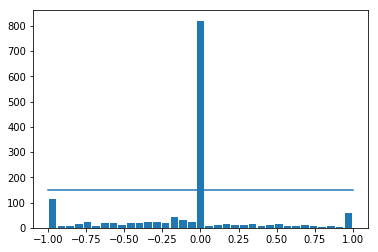

In [14]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()
num_bins = 35
samples_per_bin = 150
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [15]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

total data: 1467


In [16]:
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 670
remaining: 797


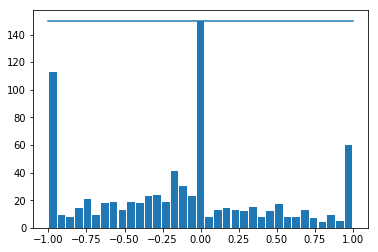

In [17]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [18]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_09_18_17_26_34_278.jpg
left        left_2019_09_18_17_26_34_278.jpg  
right       right_2019_09_18_17_26_34_278.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       5.57e-06                          
Name: 7, dtype: object


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

Training Samples: 1912
Valid Samples: 479


Text(0.5, 1.0, 'Validation set')

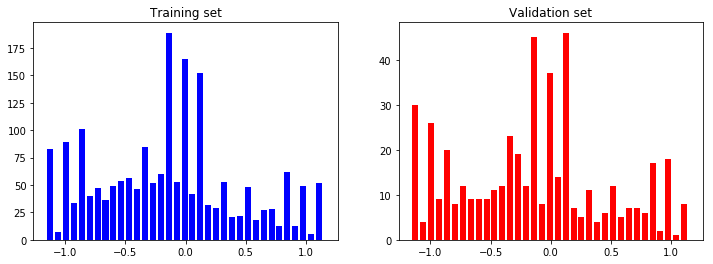

In [20]:
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def img_preprocess (img):
    img = mpimg.imread(img)
    img = img[55:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'processed Image')

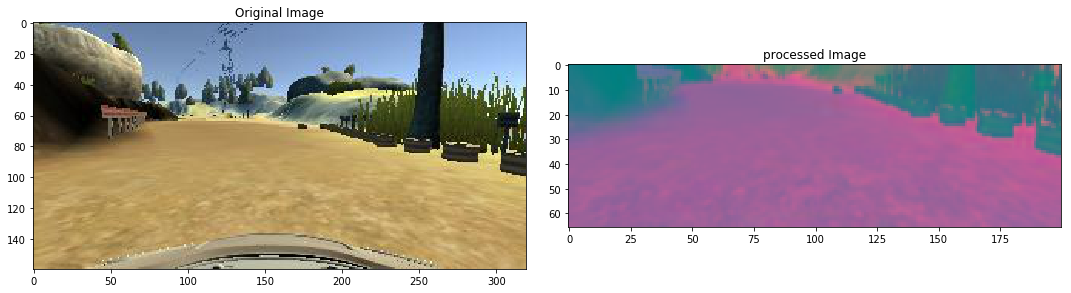

In [24]:
image = image_paths[600]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout() 

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(preprocessed_image)
axs[1].set_title('processed Image')

(1912, 66, 200, 3)


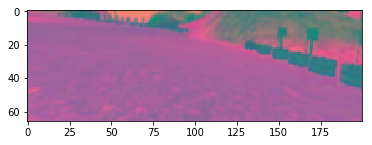

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('on')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))  
  model.add(Flatten())  
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))  
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))  
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [29]:
model = nvidia_model()
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)            

In [30]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=50, verbose=1, shuffle = 1)


Train on 1912 samples, validate on 479 samples
Epoch 1/30
1912/1912 [==============================] - 15s 8ms/step - loss: 0.8621 - val_loss: 0.3536
Epoch 2/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.4248 - val_loss: 0.3491
Epoch 3/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.3807 - val_loss: 0.3456
Epoch 4/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.3524 - val_loss: 0.3403
Epoch 5/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.3459 - val_loss: 0.3387
Epoch 6/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.3403 - val_loss: 0.3278
Epoch 7/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.3368 - val_loss: 0.3361
Epoch 8/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.3287 - val_loss: 0.3301
Epoch 9/30
1912/1912 [==============================] - 14s 7ms/step - loss: 0.3179 - val_loss: 0.3236
Epoch 10/30
1912/1912 [==

Text(0.5, 0, 'Epoch')

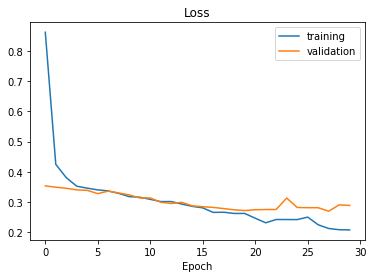

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('combobrboffroad.h5')